# Assignment 1. Analyze a real-life set of data


### DataSet: Drugs
Predict drug consumption using a set of demographic characteristics and five personality measurements

In [260]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
sns.set()
%matplotlib inline

## Read the description of the problem and identify your input and output variables. Load the data using pandas and split the data frame into X (inputs) and y (outputs)

In [261]:
#load data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"
header_neames = ["index", "age", "gender", "education", "country", "ethnicity", "nscore", "escore", "oscore", "ascore", 
                 "cscore", "impulsive", "SS", "alcohol", "amphet", "amyl", "benzos", "caffeine", "cannabis", 
                 "chocolate", "coke", "crack", "ecstasy", "heroin", "ketamine", "legal highs", "LSD", "methadone", 
                 "mushrooms", "nicotine", "semer", "VSA"]
drugs = pd.read_csv(url, names = header_neames)

print(drugs.shape)

(1885, 32)


In [262]:
#delete unnecessary column
drugs = drugs.drop(["index"], axis=1)

In [263]:
data = np.array(drugs)

#specify inputs and outputs
inputs = data[:, :12]
outputs = data[:, 12:]

print(inputs.shape, outputs.shape)

#Split dataset to test and train: train_x, train_y, test_x, test_y
train_x = inputs[:1882, :]
test_x = inputs[1882:1884, :]

train_y = outputs[:-2, :]
test_y = outputs[-2:, :]

(1885, 12) (1885, 19)


## Prepare your dataset: encode categorical variables (if any), handle missing variables (if any), generate new features (if you have some intuition that these features can be useful). Preprocess target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one.) For each transformation give a clear explanation of your motivation

We do not have missing variables, however there are categorical and normalized values

In [264]:
#encode categorical output variables
le = LabelEncoder()
drugdict = {}

for col in list(drugs.loc[:, 'alcohol':]):
    le.fit(drugs[col].drop_duplicates())
    drugdict[col] = list(le.classes_)
    drugs[col] = le.transform(drugs[col])

In [265]:
drugs.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,2,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4,0,2,0,2,3,0,4,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,1,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,2,0,0,0,0,2,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1,0,0,1,0,0,2,2,0,0


The diagram bellow shows the graph of the number of users versus the number of used illegal drugs for the decade-based separation. We can see that the distribution of the number of users is bimodal with maxima in zero and 7 drugs

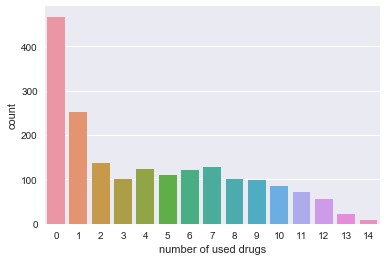

In [266]:
illegal_drugs_comp = drugs.loc[:,["amphet", "amyl", "benzos", "cannabis", "coke", "crack", "ecstasy", "heroin", 
                                  "ketamine", "legal highs", "LSD", "methadone", "mushrooms", "semer", "VSA"]]
illegal_drugs_comp["number of used drugs"] = illegal_drugs_comp.apply(lambda x: len([i for i in x if i > 1]) , axis=1)
plot_illegal_drugs = sns.countplot('number of used drugs', data=illegal_drugs_comp)

For better estimation of drugs consumption we add a binary definition of users and non-users groups using "decade-based" separation

In [267]:
drugs_num = illegal_drugs_comp > 1
drugs["user_class"] = drugs_num.apply(lambda row: 1 if reduce(lambda x, y: x or y, row) else 0, axis=1)
drugs.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,heroin,ketamine,legal highs,LSD,methadone,mushrooms,nicotine,semer,VSA,user_class
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,2,0,0,1
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,2,0,2,3,0,4,0,0,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,1,0,0,0,1
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,2,0,0,0,0,2,0,0,1
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,1,0,0,2,2,0,0,1


Before building a model, we need to analyze which inputs affect the result. Since our features are unordered, to quantify them we implemented the technique of PCA

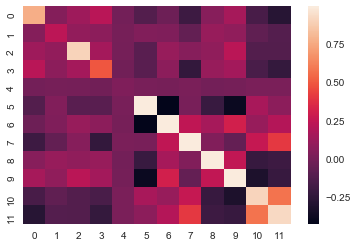

In [268]:
pca = PCA(n_components=12)
pca.fit(inputs)
PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
covariance_plot = sns.heatmap(pca.get_covariance())

From the plot of the covariance matrix we can see that most of the features except gender, country and ethnicity have strong correlation. Nevertheless, we also checked obtained result with feature importance method, that uses ensembles of decision trees (like Random Forest or Extra Trees) and compute the relative importance of each attribute

[ 0.07630798  0.02283706  0.08194654  0.06713836  0.02536007  0.1074114
  0.10594816  0.11009041  0.10362802  0.10766403  0.0922899   0.09937806]


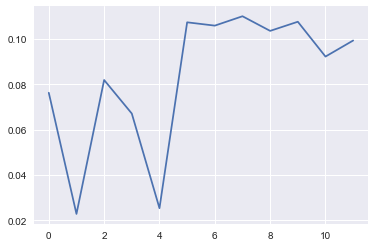

In [269]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(inputs, outputs)
# display the relative importance of each attribute
print(model.feature_importances_)
feature_importance_plot = plt.plot(model.feature_importances_)

From the above calculations, we can conclude that gender, country and ethnicity do not affect the inputs, however, we do not exclude gender, since the data actually depend on this feature, as can be seen from the plots below

## Perform an exploratory analysis of the data via visualization with Seaborn. Try to find meaningful patterns in the data which can be used to make machine learning task more specific or to help with selection and tuning ML models. Perform additional preprocessing of your data if your findings suggest this (again, all steps should be motivated). If there are several options of target variables, you can select some of them after this step with a couple of sentences explaining your choice

For an accurate analysis of the effect of the given factors on various drugs, we have constructed graphs for each item

### Alcohol

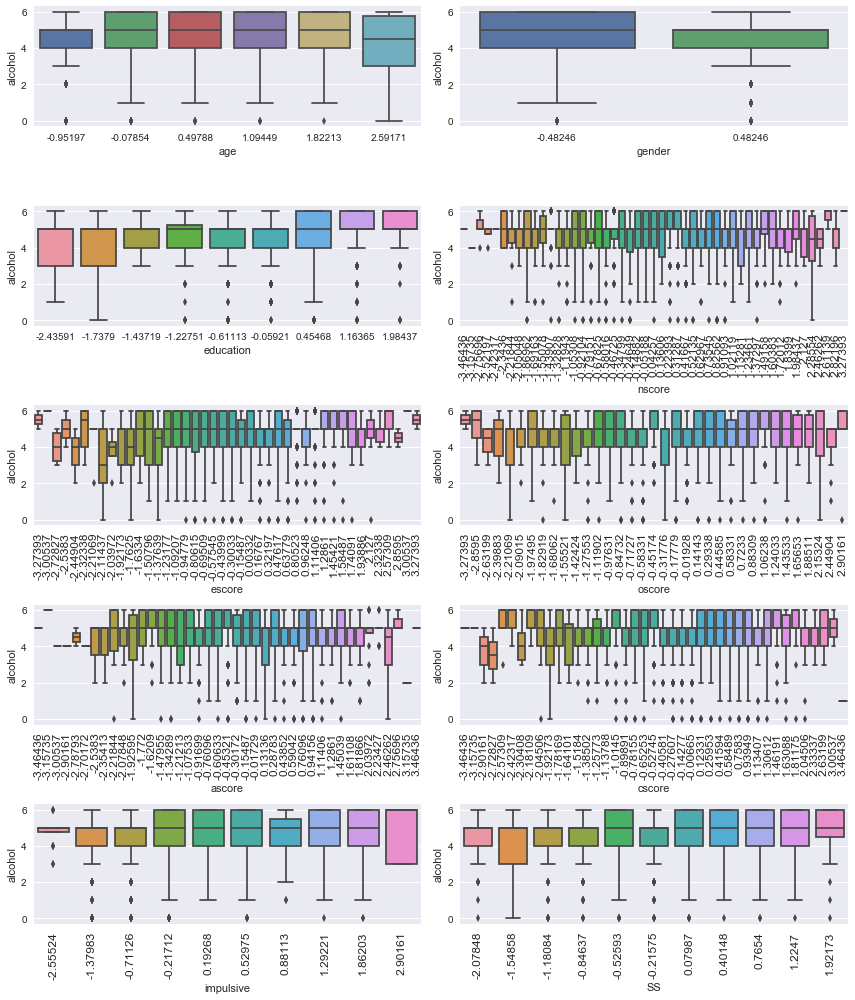

In [270]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="alcohol", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="alcohol", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="alcohol", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="alcohol", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="alcohol", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="alcohol", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="alcohol", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="alcohol", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="alcohol", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="alcohol", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Amphetamines

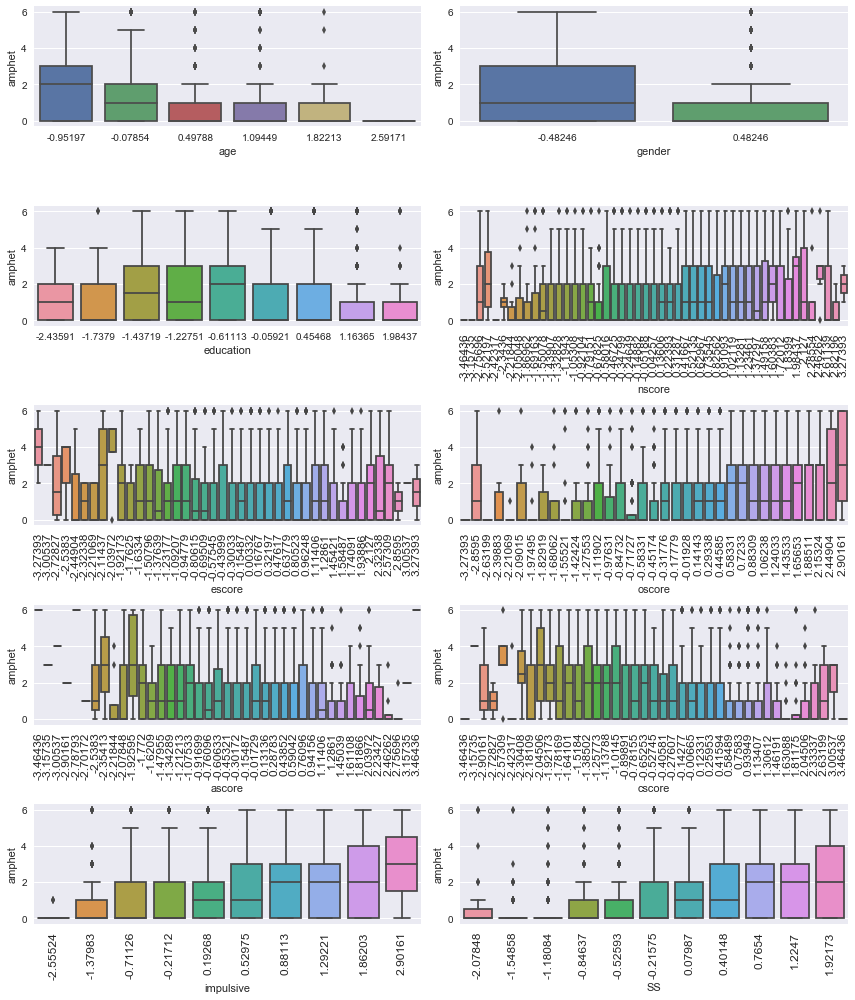

In [271]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="amphet", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="amphet", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="amphet", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="amphet", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="amphet", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="amphet", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="amphet", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="amphet", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="amphet", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="amphet", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Amyl nitrite

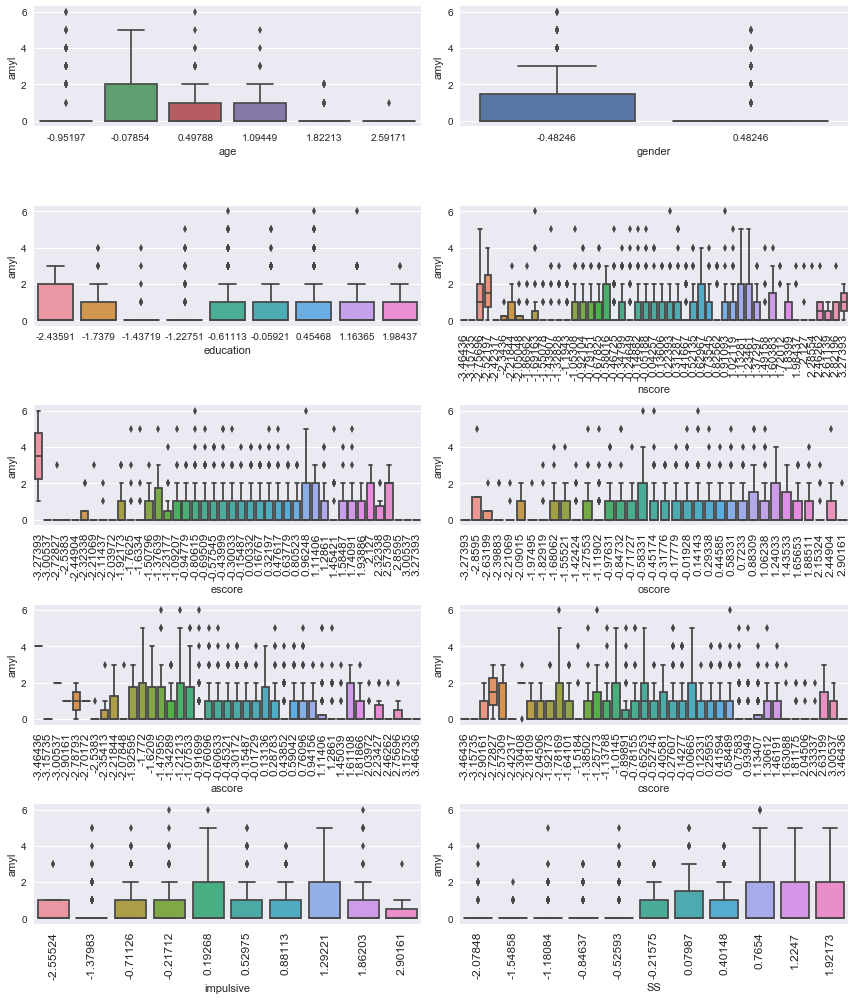

In [272]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="amyl", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="amyl", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="amyl", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="amyl", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="amyl", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="amyl", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="amyl", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="amyl", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="amyl", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="amyl", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Benzodiazepines

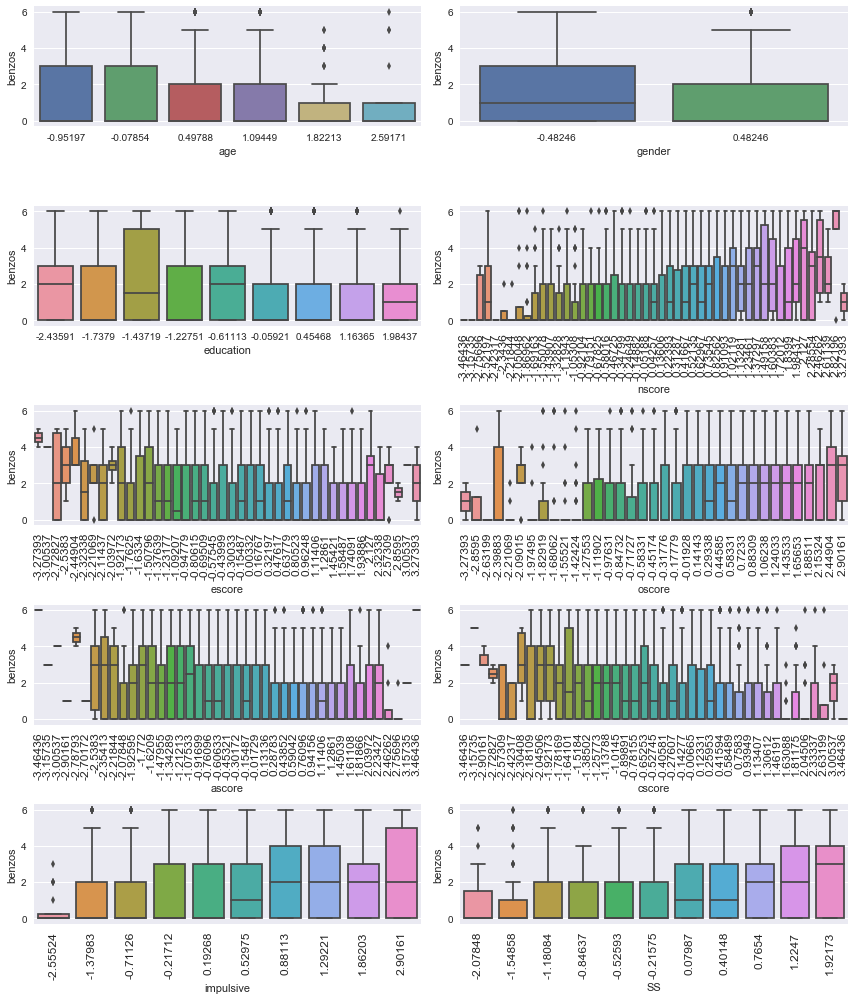

In [273]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="benzos", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="benzos", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="benzos", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="benzos", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="benzos", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="benzos", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="benzos", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="benzos", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="benzos", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="benzos", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Caffeine

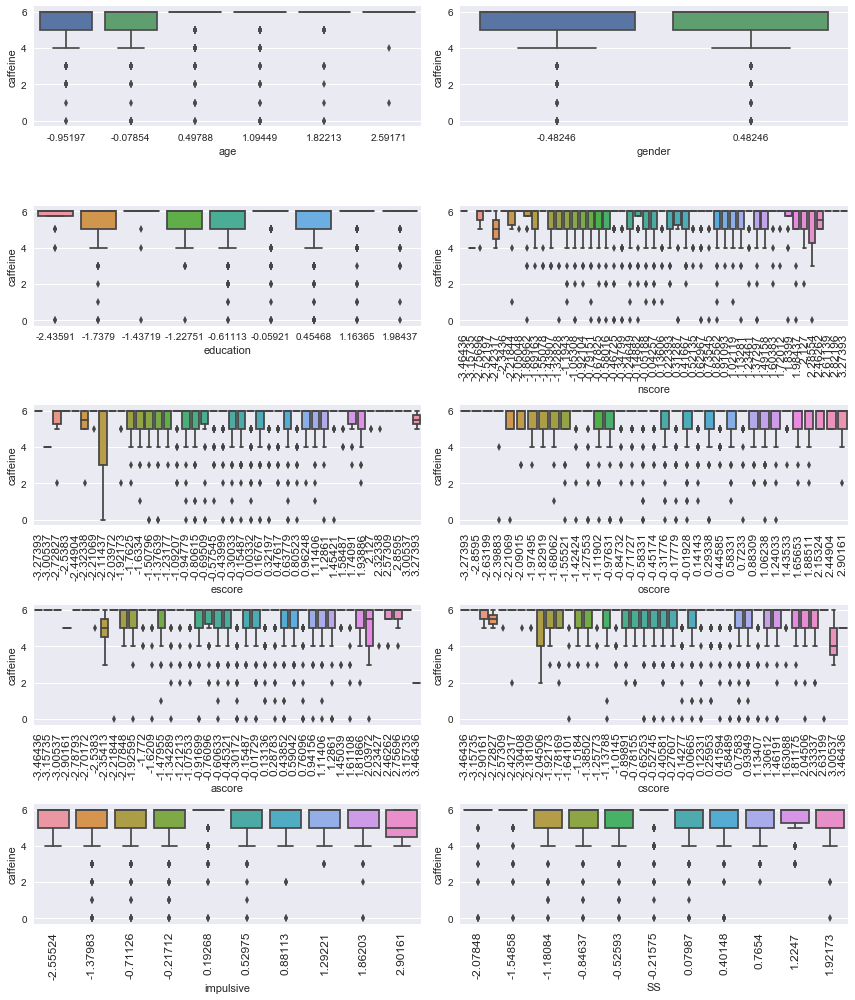

In [274]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="caffeine", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="caffeine", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="caffeine", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="caffeine", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="caffeine", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="caffeine", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="caffeine", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="caffeine", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="caffeine", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="caffeine", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Cannabis

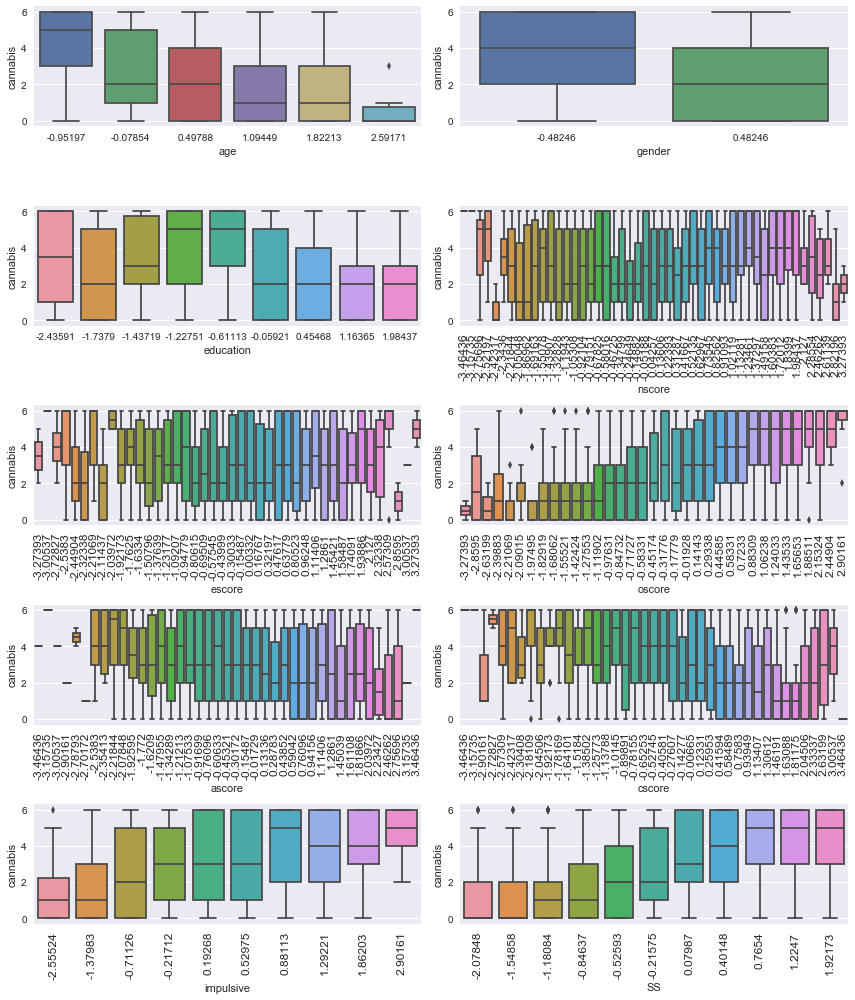

In [275]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="cannabis", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="cannabis", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="cannabis", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="cannabis", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="cannabis", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="cannabis", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="cannabis", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="cannabis", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="cannabis", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="cannabis", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Chocolate

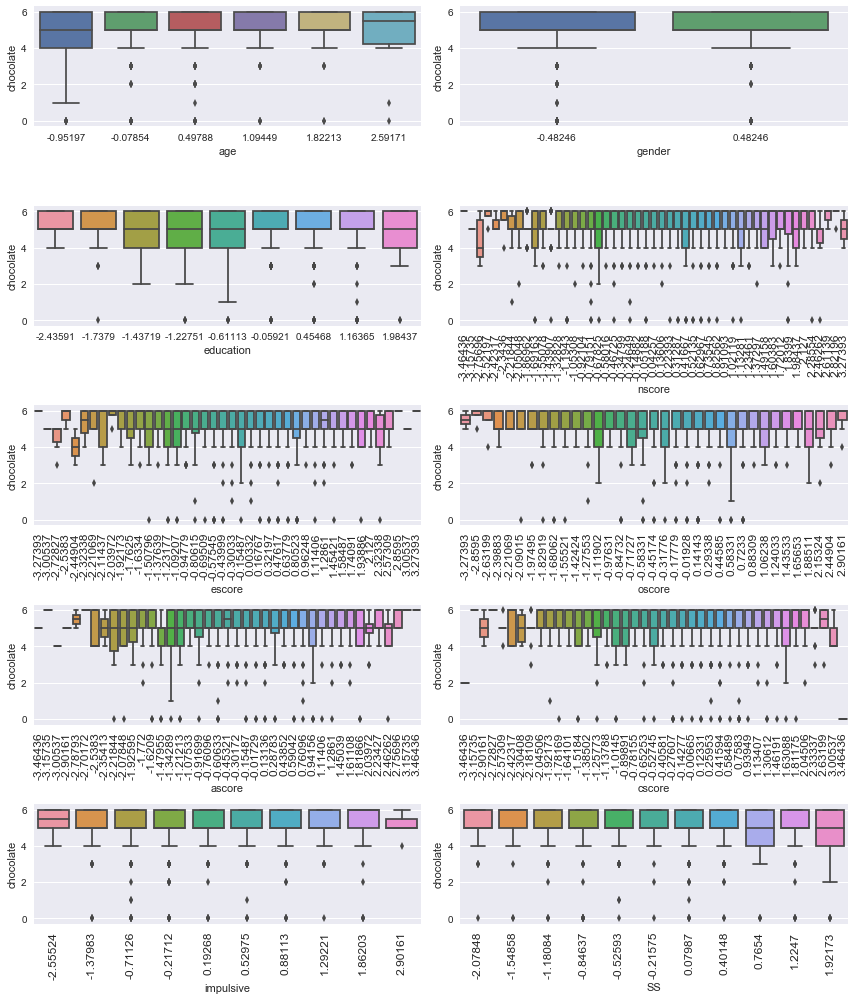

In [276]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="chocolate", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="chocolate", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="chocolate", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="chocolate", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="chocolate", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="chocolate", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="chocolate", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="chocolate", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="chocolate", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="chocolate", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Cocaine

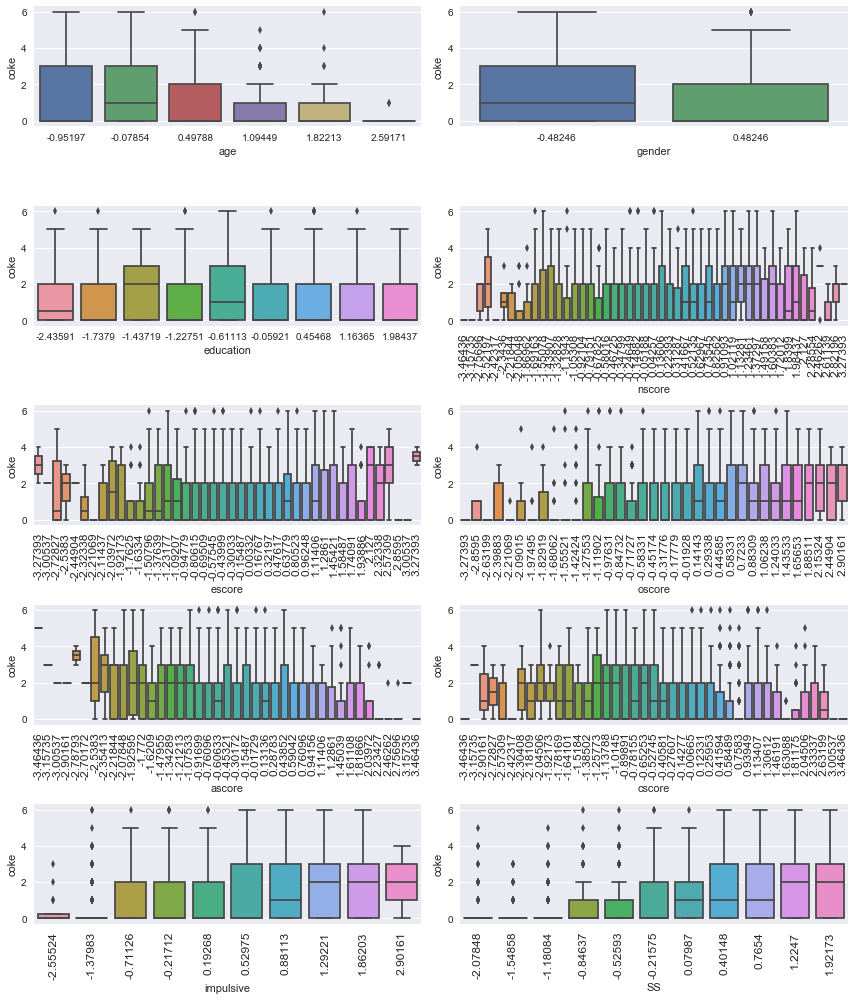

In [277]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="coke", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="coke", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="coke", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="coke", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="coke", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="coke", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="coke", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="coke", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="coke", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="coke", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Crack

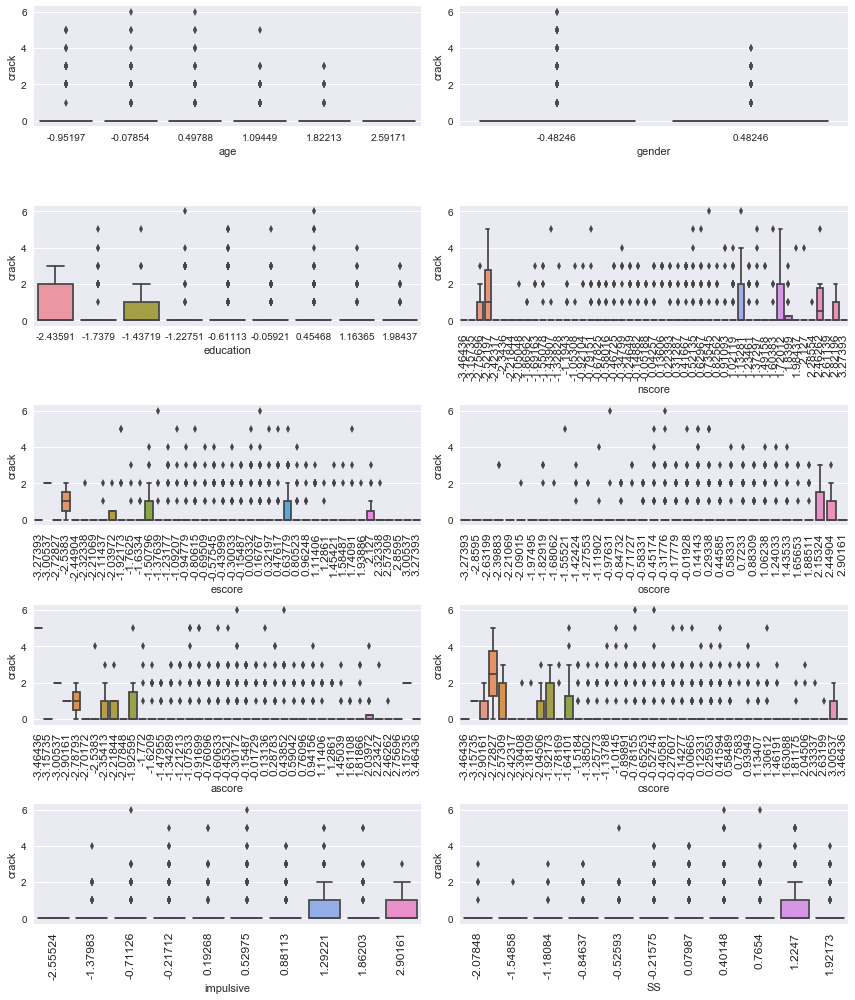

In [278]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="crack", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="crack", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="crack", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="crack", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="crack", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="crack", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="crack", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="crack", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="crack", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="crack", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Ecstasy

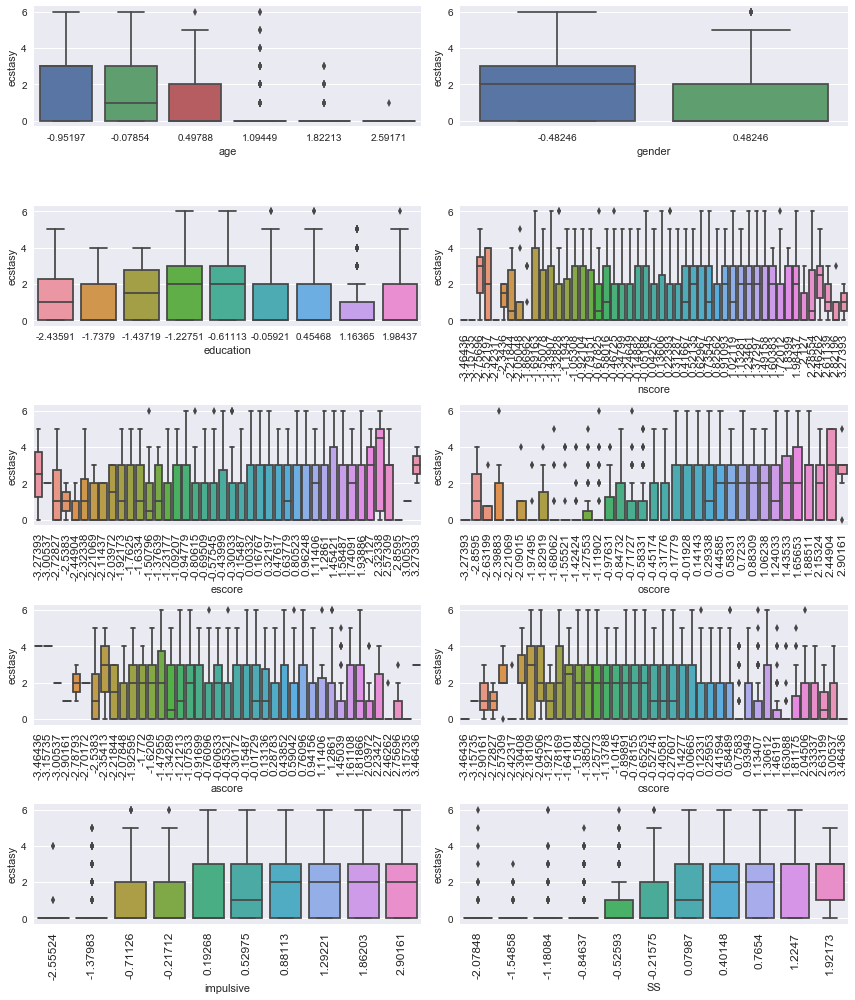

In [279]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="ecstasy", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="ecstasy", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="ecstasy", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="ecstasy", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="ecstasy", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="ecstasy", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="ecstasy", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="ecstasy", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="ecstasy", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="ecstasy", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Heroin

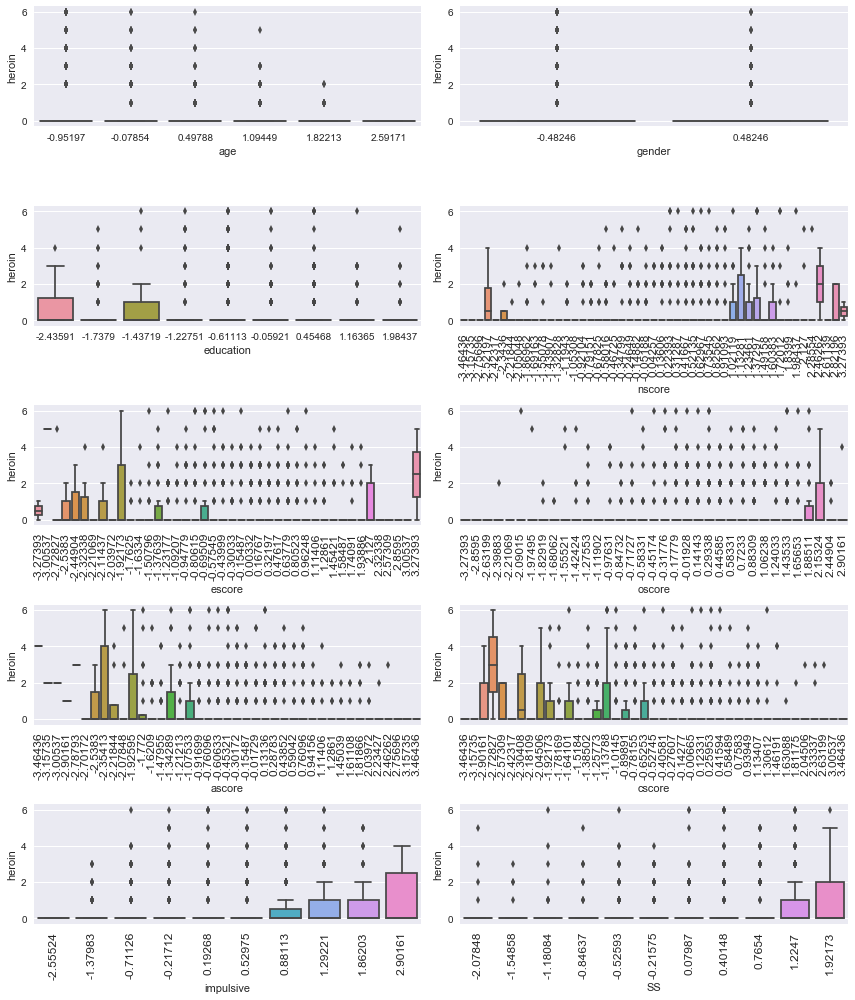

In [280]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="heroin", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="heroin", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="heroin", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="heroin", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="heroin", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="heroin", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="heroin", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="heroin", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="heroin", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="heroin", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Ketamine

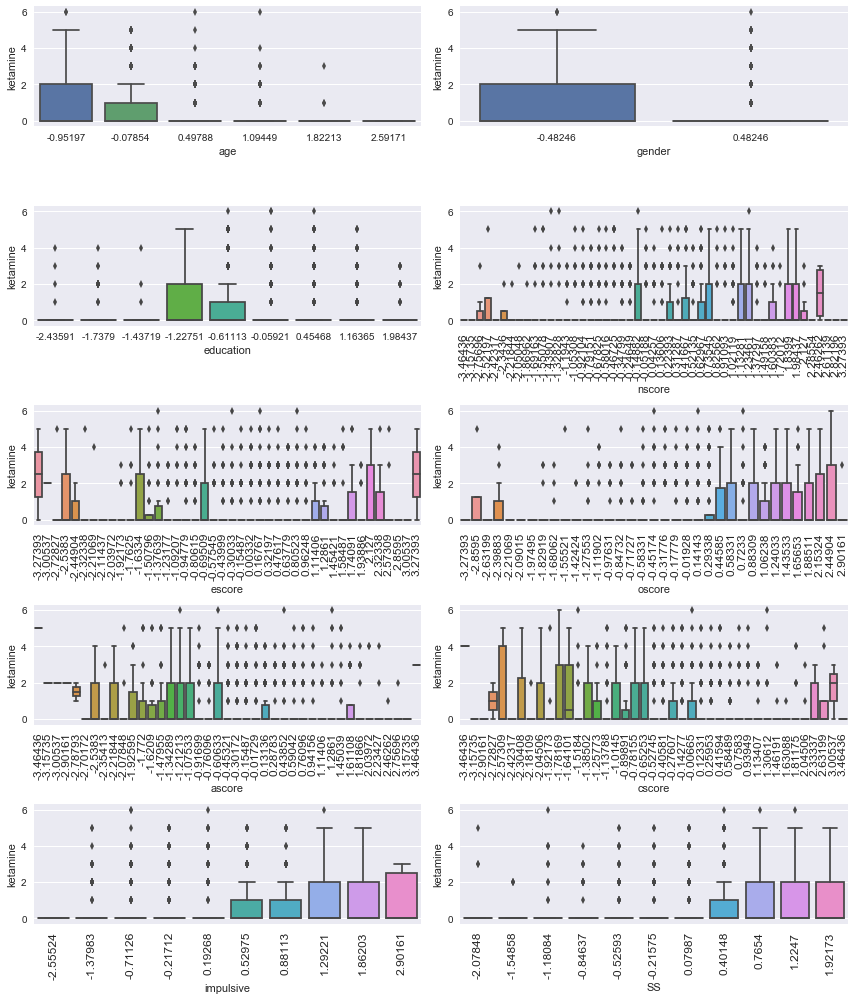

In [281]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="ketamine", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="ketamine", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="ketamine", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="ketamine", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="ketamine", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="ketamine", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="ketamine", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="ketamine", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="ketamine", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="ketamine", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Legal highs

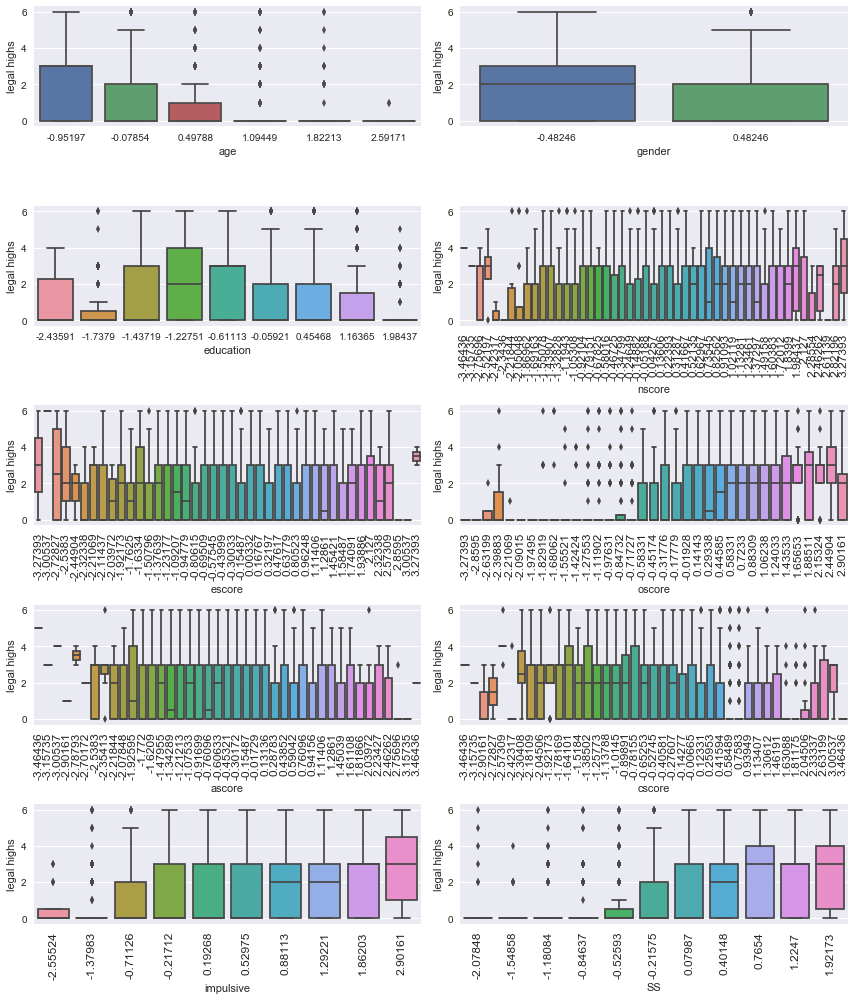

In [282]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="legal highs", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="legal highs", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="legal highs", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="legal highs", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="legal highs", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="legal highs", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="legal highs", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="legal highs", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="legal highs", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="legal highs", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### LSD

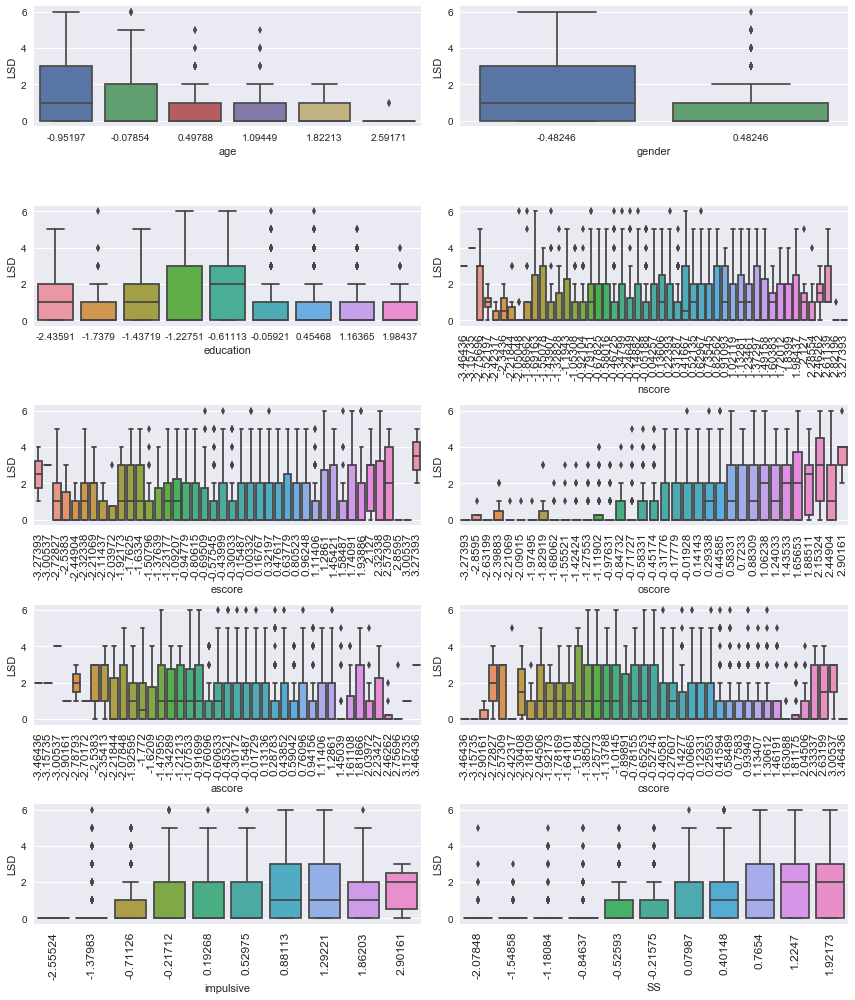

In [283]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="LSD", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="LSD", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="LSD", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="LSD", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="LSD", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="LSD", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="LSD", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="LSD", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="LSD", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="LSD", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Methadone

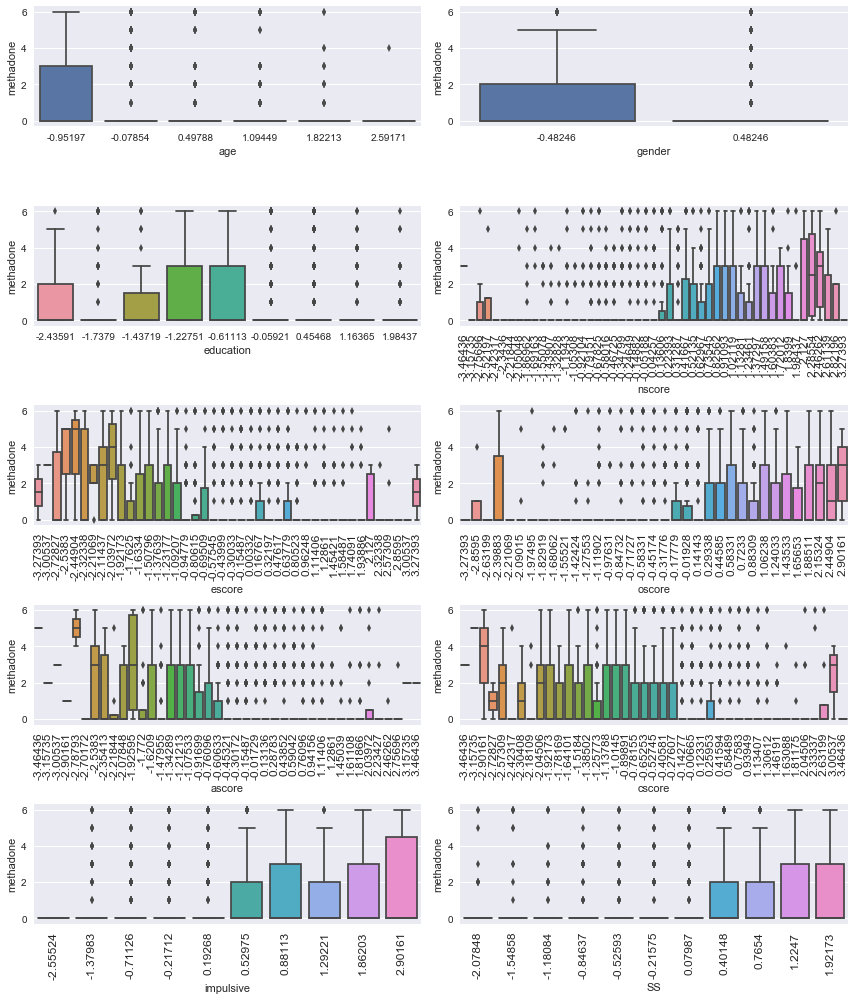

In [284]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="methadone", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="methadone", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="methadone", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="methadone", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="methadone", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="methadone", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="methadone", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="methadone", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="methadone", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="methadone", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Mushrooms

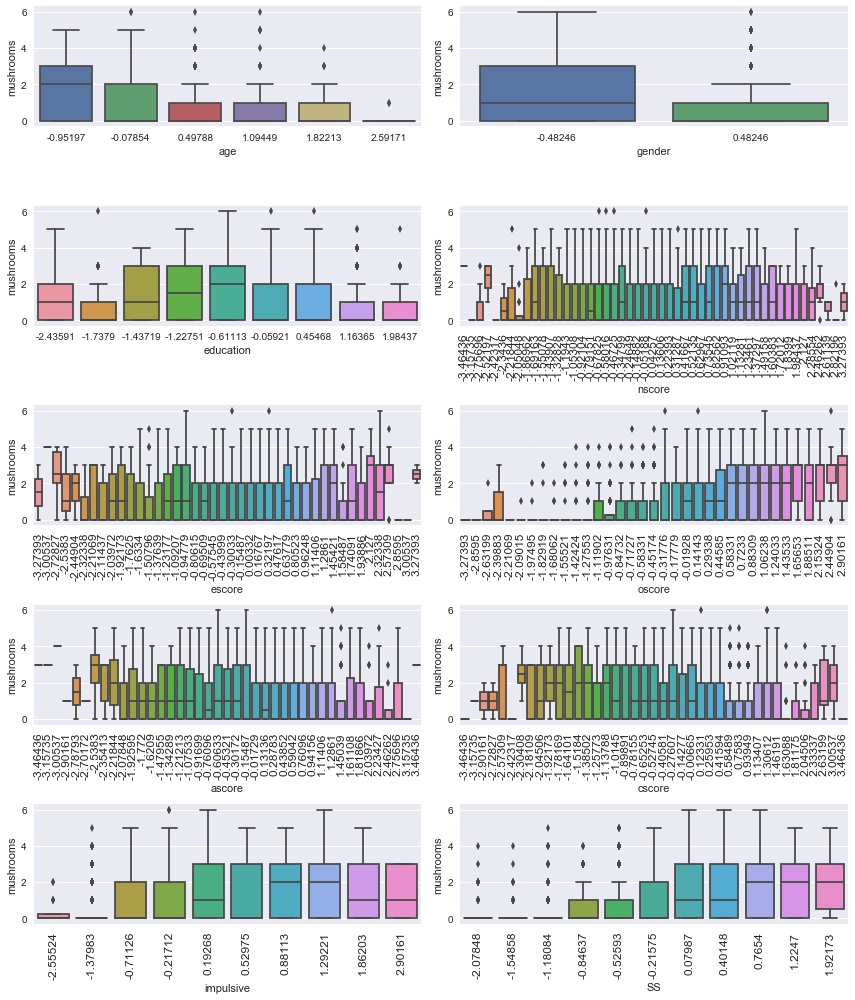

In [285]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="mushrooms", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="mushrooms", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="mushrooms", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="mushrooms", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="mushrooms", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="mushrooms", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="mushrooms", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="mushrooms", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="mushrooms", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="mushrooms", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Nicotine

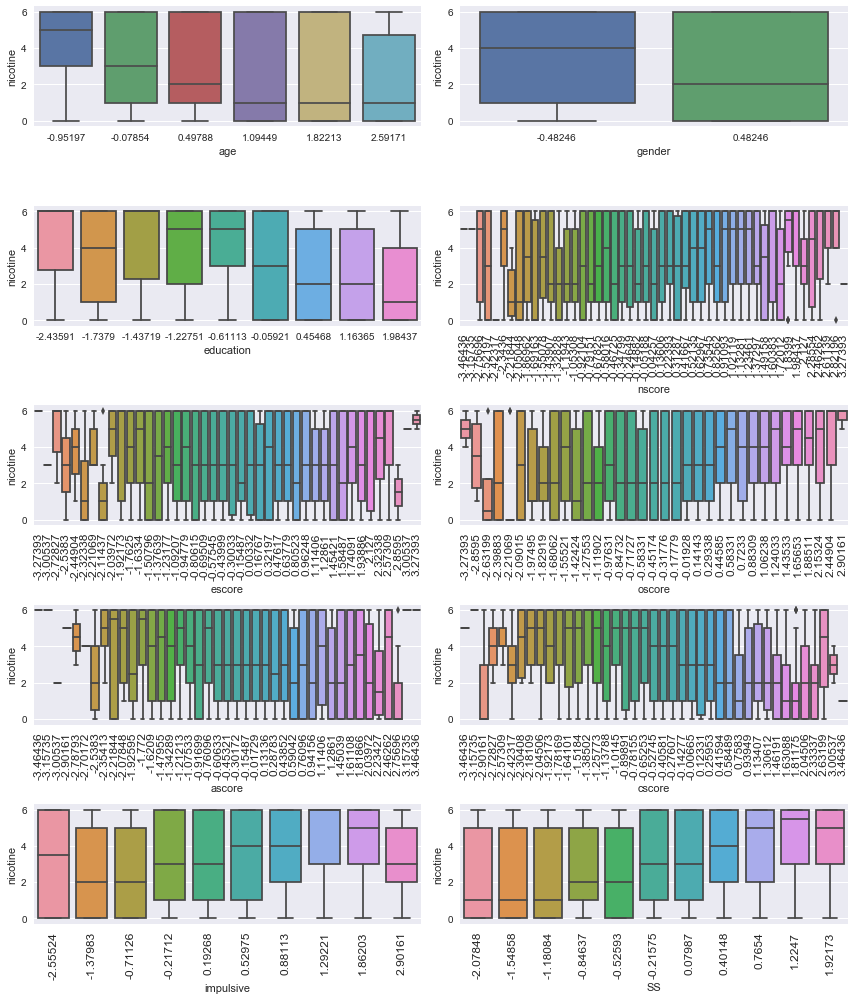

In [286]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="nicotine", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="nicotine", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="nicotine", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="nicotine", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="nicotine", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="nicotine", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="nicotine", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="nicotine", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="nicotine", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="nicotine", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### Semeron

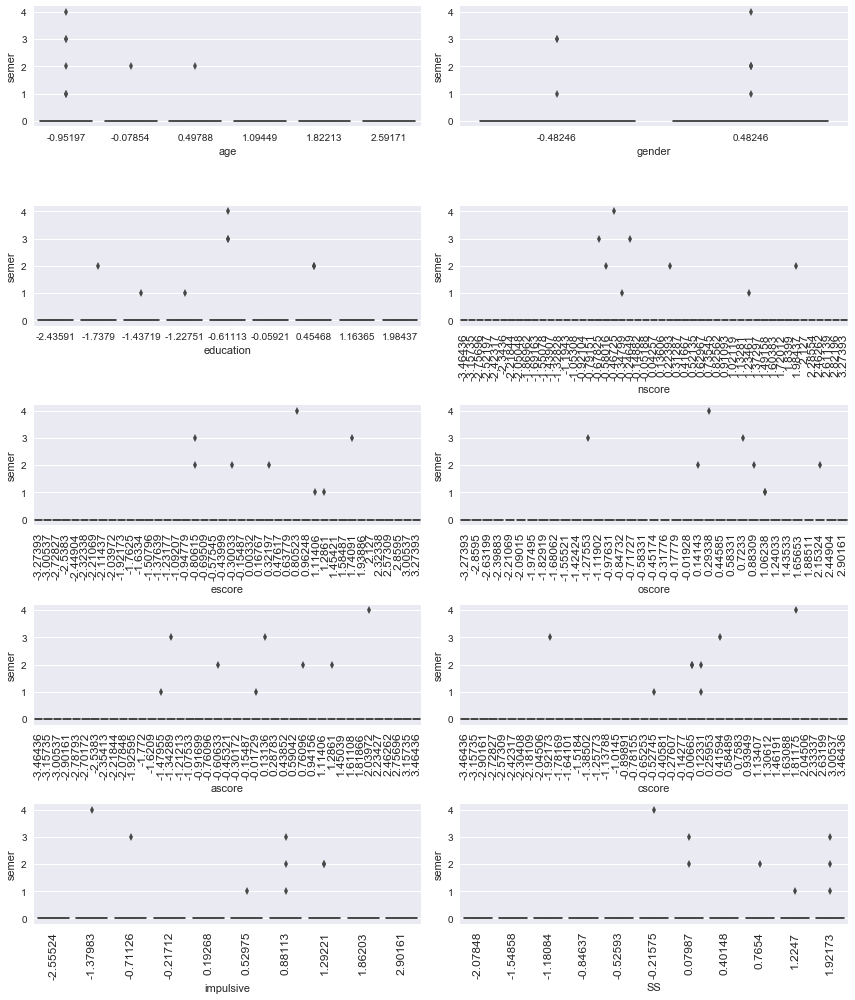

In [287]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="semer", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="semer", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="semer", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="semer", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="semer", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="semer", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="semer", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="semer", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="semer", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="semer", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

### VSA

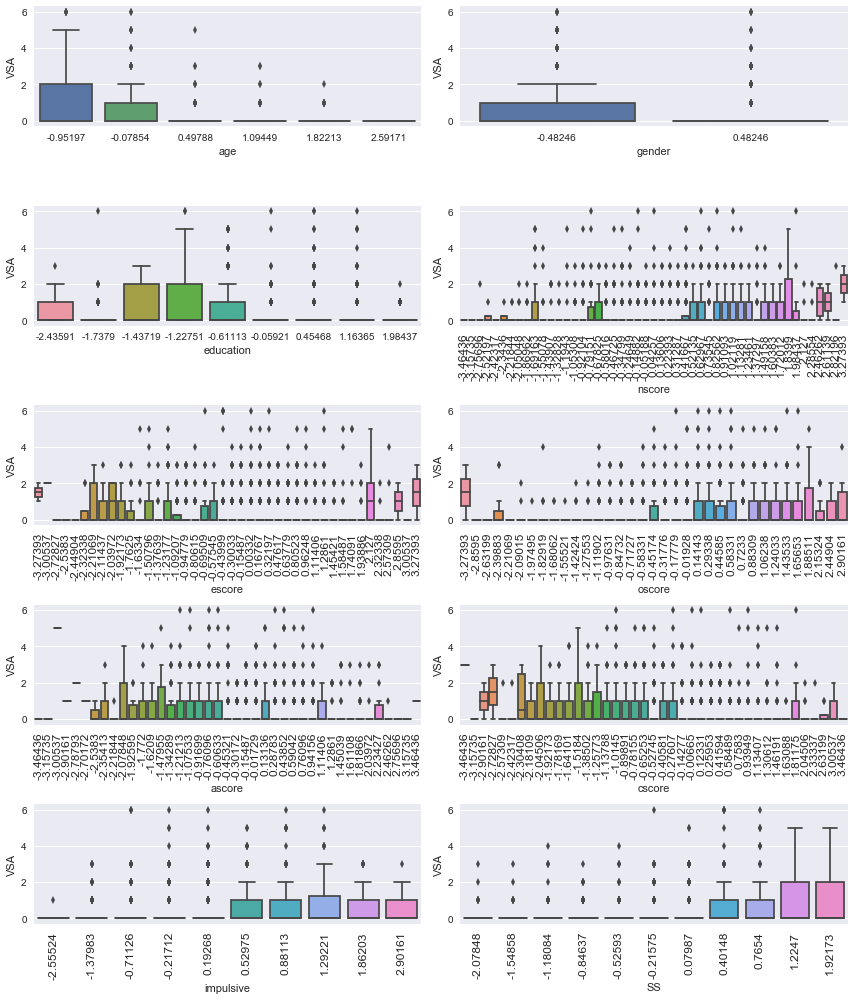

In [288]:
f, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14))
sns.boxplot(x="age", y="VSA", data=drugs, ax=axes[0,0])
sns.boxplot(x="gender", y="VSA", data=drugs, ax=axes[0,1])
sns.boxplot(x="education", y="VSA", data=drugs, ax=axes[1,0])
plot_nscore = sns.boxplot(x="nscore", y="VSA", data=drugs, ax=axes[1,1])
plot_nscore = plot_nscore.set_xticklabels(plot_nscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_escore = sns.boxplot(x="escore", y="VSA", data=drugs, ax=axes[2,0])
plot_escore = plot_escore.set_xticklabels(plot_escore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_oscore = sns.boxplot(x="oscore", y="VSA", data=drugs, ax=axes[2,1])
plot_oscore = plot_oscore.set_xticklabels(plot_oscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="ascore", y="VSA", data=drugs, ax=axes[3,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="cscore", y="VSA", data=drugs, ax=axes[3,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_ascore = sns.boxplot(x="impulsive", y="VSA", data=drugs, ax=axes[4,0])
plot_ascore = plot_ascore.set_xticklabels(plot_ascore.get_xticklabels(), rotation = 90, fontsize = 12)
plot_cscore = sns.boxplot(x="SS", y="VSA", data=drugs, ax=axes[4,1])
plot_cscore = plot_cscore.set_xticklabels(plot_cscore.get_xticklabels(), rotation = 90, fontsize = 12)
f.tight_layout()

Significant differences in personality factor scores are observed between various drugs. The universal relationship between personality profile and risk of drug consumption can generally be described as follows: an increase in scores of neuroticism and openness to experience entails an increase in the risk of use, whereas an increase in the scores of agreeableness and conscientiousness entails a decrease in risk of use. Thus for each drug, drug users scored higher on N and O, and lower on A and C when compared to drug non-users. Furthermore, we can see, that for semeron there is not enough data to draw any conclusions, therefore, we exclude this parameter from further analysis

## Build a proper cross-validation procedure; select an appropriate measure of quality. Choose an ML model reasonably; look for a good set of hyperparameters. Use the prepared cross-validation procedure to estimate the quality of prediction

### Based on the made analysis, we have allocated for each drug the parameters that affect them most and apply different classifiersand models to construct the most effective prediction

### Alcohol

Identify features (x) and targets (y), as well as split data into x and y

In [467]:
x = drugs[["age", "education", "nscore", "SS", "gender"]]

In [468]:
y = drugs['alcohol']

Check NA values via count() and then drop columns with NaNs via dropna()

In [291]:
y.value_counts()

0    976
2    243
1    230
3    198
6    102
4     75
5     61
Name: amphet, dtype: int64

In [292]:
x.count()

age          1885
nscore       1885
oscore       1885
cscore       1885
impulsive    1885
SS           1885
dtype: int64

In [293]:
print(x.shape)
x = x.dropna(axis=0)
x
y.shape

(1885, 6)


(1885,)

Logistic regression classifier

In [469]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.410079575597


In [470]:
#Cross-validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.481481481481


KNN Classifier

In [471]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9294429708222812


In [472]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.31746031746


Decision tree

In [473]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.933156498674


In [474]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.259259259259


SVC

In [475]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.422281167109


In [476]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.497354497354


## Amphetamines

In [464]:
x = drugs[["age", "nscore", "oscore", "cscore", "impulsive", "SS"]]

In [465]:
y = drugs['amphet']

Logistic regression classifier

In [294]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.515649867374


In [295]:
#Cross-validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.513227513228


KNN Classifier

In [296]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9994694960212201


In [297]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.354497354497


Decision tree

In [298]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.999469496021


In [299]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.354497354497


SVC

In [300]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.523607427056


In [301]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.518518518519


## Amyl nitrite

In [302]:
x = drugs[["nscore", "oscore", "cscore", "SS"]]

In [303]:
y = drugs['amyl']

Logistic regression classifier

In [304]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.692307692308


In [305]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.708222811671


KNN Classifier

In [306]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9978779840848806


In [307]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.534391534392


Decision tree

In [308]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.997877984085


In [309]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.566137566138


SVC

In [310]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.692307692308


In [311]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.703703703704


## Benzodiazepines

In [312]:
x = drugs[["age", "nscore", "escore", "impulsive", "SS", "gender"]]

In [313]:
y = drugs["benzos"]

Logistic regression classifier

In [314]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.527851458886


In [315]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.560846560847


KNN Classifier

In [316]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9957559681697613


In [317]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.365079365079


Desicion tree

In [318]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.99575596817


In [319]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.375661375661


SVC

In [320]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.531564986737


In [321]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.555555555556


## Cannabis

In [322]:
x = drugs[["age", "education", "oscore", "ascore", "cscore", "impulsive"]]

In [323]:
y = drugs["cannabis"]

Logistic regression classifier

In [324]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.395225464191


In [325]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.396825396825


KNN Classifier

In [326]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9994694960212201


In [327]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.291005291005


Desicion tree

In [328]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.999469496021


In [329]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.275132275132


SVC

In [330]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.429177718833


In [331]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.412698412698


## Chocolate

In [332]:
x = drugs[["age", "escore", "cscore", "gender"]]

In [333]:
y = drugs["chocolate"]

Logistic regression classifier

In [334]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.430769230769


In [335]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.444444444444


KNN Classifier

In [336]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.8694960212201591


In [337]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.359788359788


Desicion tree

In [338]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.875331564987


In [339]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.328042328042


SVC

In [340]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.442970822281


In [341]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.42328042328


## Cocaine

In [342]:
x = drugs[["age", "oscore", "ascore", "impulsive", "SS"]]

In [343]:
y = drugs["coke"]

Logistic regression classifier

In [344]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.549602122016


In [345]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.582010582011


KNN Classifier

In [346]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9952254641909815


In [347]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.439153439153


Desicion tree

In [348]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.995225464191


In [349]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.428571428571


SVC

In [350]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.557559681698


In [351]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.566137566138


## Caffeine

In [352]:
x = drugs[["age", "education", "oscore", "ascore", "impulsive", "SS"]]

In [353]:
y = drugs["caffeine"]

Logistic regression classifier

In [354]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.73474801061


In [355]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.761904761905


KNN Classifier

In [356]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9973474801061007


In [357]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.624338624339


Desicion tree

In [358]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.997347480106


In [359]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.608465608466


SVC

In [360]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.73474801061


In [361]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.761904761905


## Crack

In [362]:
x = drugs[["escore", "cscore"]]

In [363]:
y = drugs["crack"]

Logistic regression classifier

In [364]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.863129973475


In [365]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.888888888889


KNN Classifier

In [366]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.8297082228116711


In [367]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.761904761905


Desicion tree

In [368]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.89124668435


In [369]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.835978835979


SVC

In [370]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.863129973475


In [371]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.888888888889


## Ecstasy

In [372]:
x = drugs[["age", "SS", "gender"]]

In [373]:
y = drugs["ecstasy"]

Logistic regression classifier

In [374]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.550663129973


In [375]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.539682539683


KNN Classifier

In [376]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.4588859416445623


In [377]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.380952380952


Desicion tree

In [378]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.567639257294


In [379]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.571428571429


SVC

In [380]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.554376657825


In [381]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.566137566138


## Heroin

In [382]:
x = drugs[["age", "impulsive", "gender"]]

In [383]:
y = drugs["heroin"]

Logistic regression classifier

In [384]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.851458885942


In [385]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.862433862434


KNN Classifier

In [386]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.7310344827586207


In [387]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.793650793651


Desicion tree

In [388]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.85198938992


In [389]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.862433862434


SVC

In [390]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.851458885942


In [391]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.862433862434


## Ketamine

In [392]:
x = drugs[["age", "escore", "ascore", "impulsive", "SS"]]

In [393]:
y = drugs["ketamine"]

Logistic regression classifier

In [394]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.790450928382


In [395]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.772486772487


KNN Classifier

In [396]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9962864721485412


In [397]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.677248677249


Desicion tree

In [398]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.996286472149


In [399]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.671957671958


SVC

In [400]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.790450928382


In [401]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.772486772487


## Legal highs

In [402]:
x = drugs[["age", "escore", "ascore", "cscore", "SS", "gender"]]

In [403]:
y = drugs["legal highs"]

Logistic regression classifier

In [404]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.629708222812


In [405]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.62962962963


KNN Classifier

In [406]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9973474801061007


In [407]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.518518518519


Desicion tree

In [408]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.997347480106


In [409]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.513227513228


SVC

In [410]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.640318302387


In [411]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.613756613757


## LSD

In [412]:
x = drugs[["age", "nscore", "escore", "oscore", "impulsive", "gender"]]

In [413]:
y = drugs["LSD"]

Logistic regression classifier

In [414]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.586737400531


In [415]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.597883597884


KNN Classifier

In [416]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9989389920424403


In [417]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.513227513228


Desicion tree

In [418]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.998938992042


In [419]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.444444444444


SVC

In [420]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.598408488064


In [421]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.592592592593


## Methadone

In [422]:
x = drugs[["age", "education", "escore", "oscore", "gender"]]

In [423]:
y = drugs["methadone"]

Logistic regression classifier

In [424]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.753315649867


In [425]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.761904761905


KNN Classifier

In [426]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9708222811671088


In [427]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.597883597884


Desicion tree

In [428]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.972413793103


In [429]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.640211640212


SVC

In [430]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.758090185676


In [431]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.767195767196


## Mushrooms

In [432]:
x = drugs[["escore", "gender"]]

In [433]:
y = drugs["mushrooms"]

Logistic regression classifier

In [434]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.520954907162


In [435]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.544973544974


KNN Classifier

In [436]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.3941644562334218


In [437]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.386243386243


Desicion tree

In [438]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.531034482759


In [439]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.550264550265


SVC

In [440]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.521485411141


In [441]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.544973544974


## Nicotine

In [442]:
x = drugs[["nscore", "escore", "cscore", "gender"]]

In [443]:
y = drugs["nicotine"]

Logistic regression classifier

In [444]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.371352785146


In [445]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.354497354497


KNN Classifier

In [446]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 0.9687002652519894


In [447]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.227513227513


Desicion tree

In [448]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.96976127321


In [449]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.201058201058


SVC

In [450]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.378779840849


In [451]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.375661375661


## VSA

In [452]:
x = drugs[["age", "education", "escore", "ascore", "cscore", "SS"]]

In [453]:
y = drugs["VSA"]

Logistic regression classifier

In [454]:
clf = LogisticRegression()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.770822281167


In [455]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.798941798942


KNN Classifier

In [456]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x, y)
y_predicted = clf.predict(x)
print('Accuracy of prediction is {}'.format(accuracy_score(y, y_predicted)))

Accuracy of prediction is 1.0


In [457]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.656084656085


Desicion tree

In [458]:
clf = tree.DecisionTreeClassifier()
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 1.0


In [459]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.671957671958


SVC

In [460]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Accuracy when trained on all dataset', accuracy_score(clf.predict(x), y))

Accuracy when trained on all dataset 0.771883289125


In [461]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, stratify = None, random_state = 0)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy on a test subset', accuracy_score(y_pred, y_test))

Accuracy on a test subset 0.798941798942


The first step for the drugs risk evaluation is the construction of classifiers. We tested the 4 methods (logistic regression, KNN, desicion tree, SVC) and selected the best one. Each of given inputs is an important predictor for at least five drugs. However, there is no single most effective classifier which uses all input features

The use of a feature in the best classifier can be interpreted as ‘ranking by fact’. We can note that this ranking by fact is very different from other rankings. For example, gender is shown not to be the most informative
measure in accordance with PCA, but it is used in the classifiers for
10 drugs. We also found some unexpected outcomes: for example, in the dataset the fraction of females who are alcohol users is greater than that fraction of males but the greater proportion of males drink coffee. The fraction of males who do not eat chocolate is greater than for females. The conditional distributions for nicotine meets the common sense expectations.
The next most informative input features are E and SS which are used in the best classifiers for nine drugs. Features O, C, and Imp. are used in the best classifiers for eight drugs. Features N and A are used in the best classifiers for six drugs. Thus, personality factors are associated with drug use and each one impacts on specific drugs. Finally, Edu. is used in the best classifiers for five drugs.
To predict the usage of the most drugs DT is the best classifier, kNN is the best classifier for cocaine and caffeine users. Moreover, SVC is appropriate for alcohol, cannabis and other several drugs.